# Taller #3 
## Simulador de vuelta e-kart parte 2
### Daniel Felipe Jaramillo Arenas, 201414139

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm
import os
from scipy import ndimage
import pandas as pd
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

Populating the interactive namespace from numpy and matplotlib


### Lectura de archivos VBox

A continuación se encuentra la función "datos" esta tiene como único parámetro la ruta del archivo y retorna un Dataframe en el cual se consolida la información de:

1. Tiempo
2. Latitud
3. Longitud
4. Velocidad
5. Altura

Esta función está en capacidad de leer los datos de los dos modelos de VBox presentes en la universidad. Para efectos prácticos en la carpeta [Taller_3](https://github.com/dafeja96/Herramientas-Computacionales-IMEC3602/tree/master/Taller_3) de este repositorio se crearon dos carpetas las cuales contienen los datos suministrados del kart eléctrico y del kart con motor de combustión los nombre de estas carpetas son DataElec y DataCom respectivamente.

In [2]:
def datos(direccion):
    with open(direccion, encoding="latin-1") as vboxdata:
        section = []
        time = []
        lat = []
        longi = []
        vel = []
        height = []
        vertv = []
        for line in vboxdata:
            if line[0] == '[':
                section = str.replace(line, "\n","")
                continue
            if section == '[data]':
                linesplit = str.replace(line, " \n","").split(' ')
                time.append(float(linesplit[1][0:2])*3600+float(linesplit[1][2:4])*60+float(linesplit[1][4:]))
                lat.append(float(linesplit[2]))
                longi.append(float(linesplit[3]))
                vel.append(float(linesplit[4]))
                height.append(float(linesplit[6]))

    time = np.asarray(time)
    lat = np.asarray(lat)
    longi = np.asarray(longi)
    vel = np.asarray(vel)
    height = np.asarray(height)
    time_base = time[0]
    time = time - time_base
    lat = lat/60.0
    longi = -longi/60.0
    datos={'time':time,'lat':lat,'longi':longi,'vel':vel,'height':height}
    resul= pd.DataFrame(data=datos,columns=['time','lat','longi','vel','height'])
    return (resul)


### Rendimiento en pista

Antes de discutir el rendimiento de cada uno de los karts se encuentra la función "aVueltafil" esta función es la que se encarga a partir de los datos ya guardados como un Dataframe sacar la siguiente información:

1. Recorrido del kart.
2. Tiempo de vuelta.
3. Velocidad Máxima.
4. Aceleración Máxima.
5. Grafica de velocidad respecto al tiempo.
6. Grafica de aceleración respecto al tiempo.

In [3]:
def aVueltafil(datos,i,f,sig):
    y=datos['lat'][i:f]
    x=datos['longi'][i:f]
    vel=datos['vel'][i:f]
    tiempo=datos['time'][i:f]
    tiem=np.array(tiempo)
    ddt=tiem[1]-tiem[0]
    acel=ndimage.gaussian_filter1d(vel*(5/18), sigma=sig, order=1, mode='wrap') / ddt
    #acel=numpy.gradient(vel*(5/18))
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    fig,axs=subplots(1,1)
    norm = plt.Normalize(vel.min(), vel.max())
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(vel)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    fig.colorbar(line)
    axs.autoscale()
    title("1. Recorrido")
    plt.axis('off')
    plt.show()
    
    figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plot(tiempo-tiempo[i],vel)
    title("2. Velocidad contra tiempo")
    xlabel("Tiempo [s]")
    ylabel ("Velocidad [km/h]")
    plt.subplot(1,2,2)
    plot(tiempo-tiempo[i],acel)
    title("3. Aceleración contra tiempo")
    xlabel("tiempo [s]")
    ylabel ("Aceleracion [m/s^2]")
    
    Vmax=vel.max()
    Tvuelta=datos['time'][f]-datos['time'][i]
    
    print('El tiempo de vuelta fue: ',Tvuelta,'s')
    print('La velocidad maxima fue: ',Vmax,'km/h')
    print('La aceleración maxima fue: ',acel.max(),'m/s^2')

In [4]:
datosElec=datos('DataElec/VBS__047.VBO')
datosCom=datos('DataCom/VBOX0019.VBO')

###### 1. Kart con motor de combustión interna

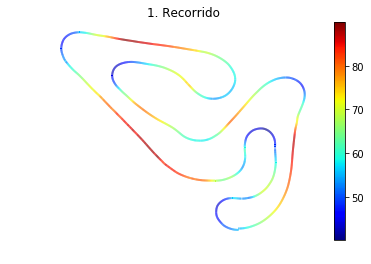

El tiempo de vuelta fue:  55.85 s
La velocidad maxima fue:  89.951 km/h
La aceleración maxima fue:  3.65604454288 m/s^2


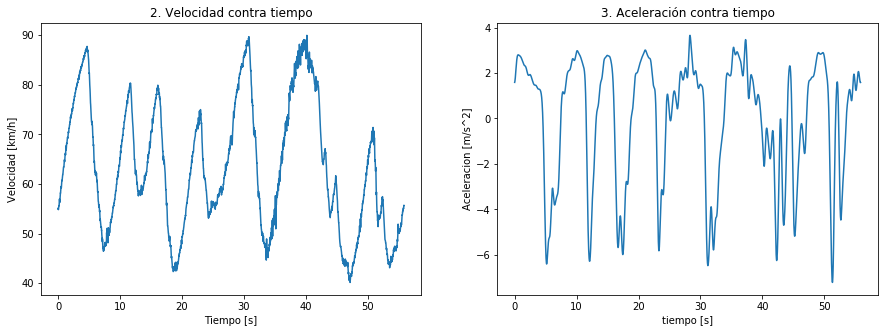

In [5]:
aVueltafil(datosCom,15690,21275,20)

El archivo de datos utilizado para este análisis fue el VBOX0019.VBO. En la vuelta expuesta en la gráfica 1 se puede observar el recorrido realizado por el Kart y se puede observar que el comportamiento de las velocidades es el esperado alcanzado sus valores más altos en las rectas y los más bajos en las curvas. Además se tiene que la velocidad máxima alcanzada fue de $89.95 \frac{km}{h}$ y el tiempo de vuelta fue de 55.85 s. En la gráfica 3 se observa el comportamiento de la aceleración que se valor más alto fue de $3.66 \frac{m}{s^2}$ y en esta grafica de aceleración tambien se observa que debido a la forma del circuito la aceleracion es muy fluctante en el tiempo ya que el piloto requiere acelerar y frenar durante todo el recorrido.

##### 2. Kart con motor eléctrico

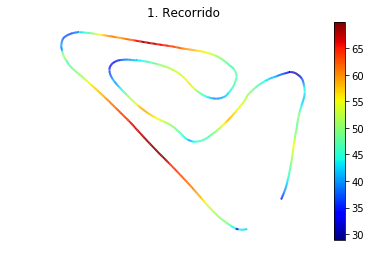

El tiempo de vuelta fue:  57.0 s
La velocidad maxima fue:  69.87 km/h
La aceleración maxima fue:  1.59378979198 m/s^2


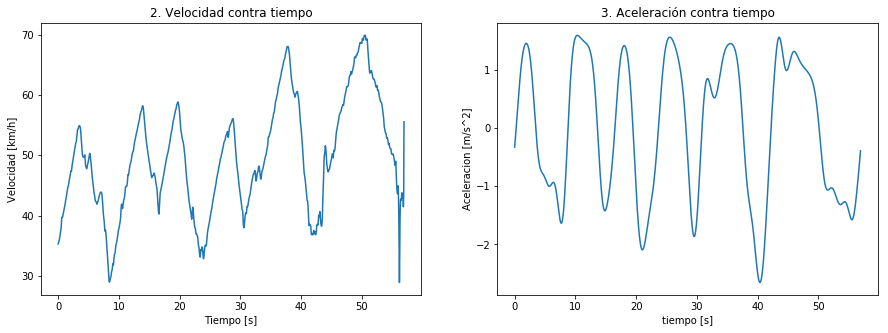

In [6]:
aVueltafil(datosElec,380,1520,15)

El archivo de datos utilizado en el caso del motor eléctrico fue el VBS__047.VBO. En este caso en la gráfica 1 se puede observar que la vuelta no está completa esto es debido a que en la última curva es posible concluir que hubo un error en el VBox que arrojo una velocidad muy alta por lo que para evitar tener valores de velocidades máximas que no tienen relación con el rendimiento real del carro es preferible para evaluar las velocidades y aceleraciones excluir este fragmento de vuelta. Con esta modificación la velocidad máxima alcanzada es de $69.87\frac{km}{h}$ y la aceleración mas alta fue de $1.59\frac{m}{s^2}$. 

En las grafica a continuación se observa el recorrido total del kart en la pista, incluyendo el fragmento antes excluido, donde se observa el error de velocidad en la última curva y donde también se observa en la gráfica de velocidades el pico de velocidad.

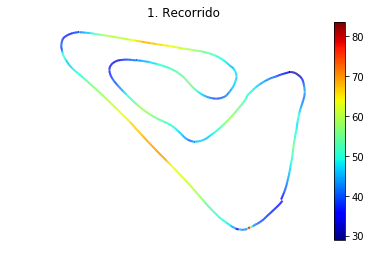

El tiempo de vuelta fue:  60.5 s
La velocidad maxima fue:  83.53 km/h
La aceleración maxima fue:  2.47922998369 m/s^2


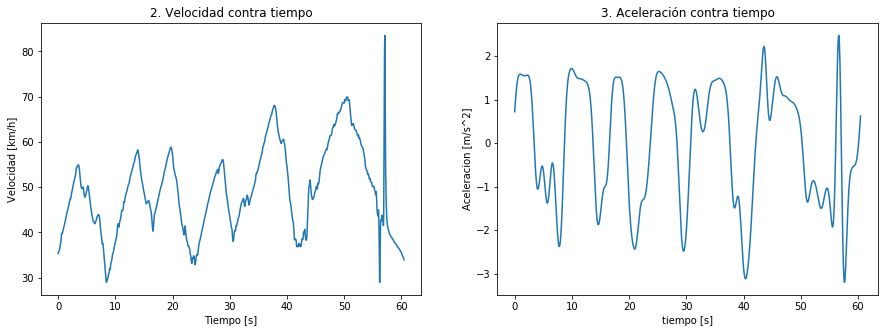

In [7]:
aVueltafil(datosElec,380,1590,10)

A pesar de que exista un error en las velocidades este último análisis es el que permite sacar el tiempo de vuelta real del kart  electrico que fue de 60.5 s

### Comparación

Al observar los recorridos del kart de combustión interna y el eléctrico se observa que aunque la pista fue la misma el circuito utilizado no fue el mismo. Esto lleva a que los tiempos de vuelta no sean comparables entre sí. Sin embargo si da una idea del rendimiento de los karts, ya que el kart a combustión interna realizo un circuito más largo y el tiempo de vuelta fue menor al eléctrico que realizo el circuito en pista más corto en 60.5 s contra 55.85 s del de combustión. En términos de velocidades máximas y aceleraciones alcanzadas en la pista el kart de combustión interna tuvo un mejor rendimiento (Tabla 1).

###### Tabla 1 Velocidades y aceleraciónes máximas
|        | Vel max [km/h] | Acel max [m/s^2] |
|--------|----------------|------------------|
| e-Kart | 69.87          | 1.59             |
| Kart   | 89.5           | 3.66             |

### Desempeño de los motores

Basado en los modelos y funciones implementados en el taller 2 es posible a partir de los datos reales del kart obtener el torque del motor, la velocidad angular y la potencia entregada. Las formulas son:

Para el torque se tiene:

$Te=\frac{((M+M_r)a_x+R_x+D_a)r}{N_c \eta_t}$ [Ecuación 1]  

Dónde:

$M=$ masa del Kart

$M_r=$ masa equivalente de los elementos rotativos

$a_x=$ aceleración

$N_c=$ relación de transmisión

$ \eta_t=$ eficiencia de la transmisión

$r=$ radio efectivo de la llanta

$R_x=f_rW $ es la fuerza de resistencia a la rodadura  

$D_A = \frac{1}{2}\rho A_f C_d v_x^2 $ es la fuerza de arrastre aerodinámico

Para la velocidad angular:

$w=\frac{v_x}{r}N_c$[Ecuación 2]

Y para la potencia:

$P=T_ew$ [Ecuación 3]

Las funciones a continuación calculan y grafican los resultados:

In [8]:
def frodadura_const(vx,wx):# w= peso del kart, vx=velocidad del kart
    fr=0.01*(1+(vx/100.0))
    return wx*fr # (N)

In [9]:
def farrastre(vx,rhox,afx,cdx): 
    return (1.0/2.0)*rhox*afx*cdx*(vx)**2 

In [10]:
def Masaequi(Iwx,Idx,Iex,Ncx,rx):
    Me=((Iwx+Idx)+(Iex*(Ncx**2)))/(rx**2)
    return (Me)

In [11]:
def omega(vx,rx,Ncx):
    om=(vx/rx)*Ncx
    return (om)

In [12]:
def rendMotor(datos,i,f,rhox,afx,cdx,rejex,Ncx,wx,Iwx,Idx,Iex,rx,efix,sig):
    vel=(datos['vel'][i:f])
    velms=(datos['vel'][i:f])*(5/18)
    tiempo=np.array((datos['time'][i:f])-(datos['time'][i]))
    ddt=tiempo[1]-tiempo[0]
    acel=ndimage.gaussian_filter1d(velms, sigma=sig, order=1, mode='wrap') / ddt
    #acel=numpy.gradient(velms)
    Rx=frodadura_const(vel,wx)
    Da=farrastre(velms,rhox,afx,cdx)
    Mr=Masaequi(Iwx,Idx,Iex,Ncx,rx)
    M=wx/9.81
    Te=(((M+Mr)*acel+Rx+Da)*rx)/(Ncx*efix)
    Te[Te<0]=0
    velAngu=omega(velms,rx,Ncx)
    Pot=Te*velAngu
    
    
    figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plot(tiempo,Te)
    title("")
    xlabel("Tiempo [s]")
    ylabel ("Torque Motor [Nm]")
    plt.subplot(2,2,2)
    plot(tiempo,velAngu)
    title("")
    xlabel("tiempo [s]")
    ylabel ("Vel Angular [rad/s]")
    plt.subplot(2,2,(3,4))
    plot(tiempo,Pot)
    title("")
    xlabel("tiempo [s]")
    ylabel ("Potencia [W]")
    return(Te,velAngu)

Los datos a continuación se obtuvieron de trabajos previos en el tema referenciados al final de este taller.[1][2]

In [13]:
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
reje=0.02 # Radio eje de las llantas (m)
efi=0.95 # Eficiencia de transmisión
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)
Ie=5.2E-3 # Inercia motor(kg m^2) 
mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
rin=0.0631 #radio interno del neumático (m)
rll=0.139 # Radio geométrico de las llantas en traseras (m)
r=0.98*rll # Radio efectivo llantas traseras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)
Iw=2*illd+2*illt
meje=3.832 # Masa del eje (kg)
Id=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

##### 1. Motor de combustión interna

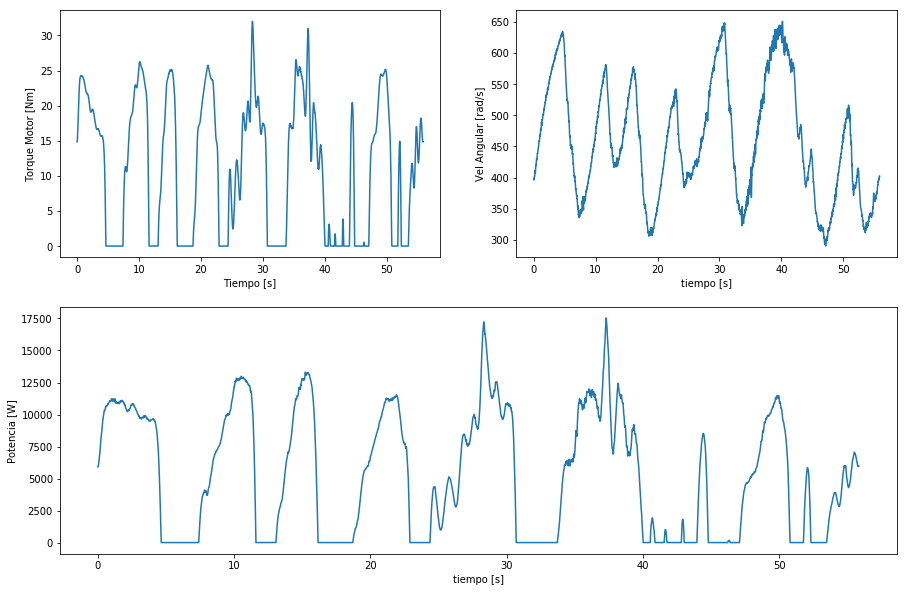

In [14]:
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
Nc=dpl/dp # Relación de Transmisión
comb=rendMotor(datosCom,15690,21275,rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi,20)

En el motor de combustión interna el torque mayor está por encima de los 30 Nm y las velocidades angulares alcanzan valores de 650 rad/s o 6207 rpm. Los tiempos en donde el torque del motor es cero y la potencia es cero se deben a los momentos en los que se frenó durante la vuelta. La potencia máxima generada por el motor fue de 17 kW aproximadamente.

##### 2. Motor eléctrico

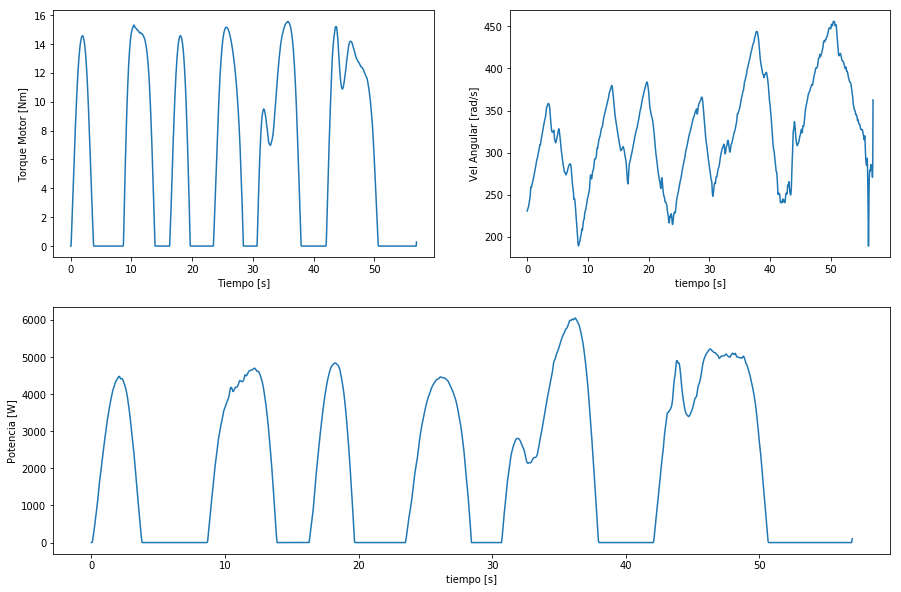

In [15]:
dp=20.0 # Dientes del piñon
dpl=64.0 # Dientes del plato
Nc=dpl/dp # Relación de Transmisión
elec=rendMotor(datosElec,380,1520,rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi,15)

En el motor eléctrico el torque máximo alcanzado fue del orden de los 16 Nm y las velocidades angulares máximas fueron de 450 rad/s o 4300 rpm aproximadamente, la potencia máxima es de 6 kW. En comparación con el motor de combustión la potencia generada por el motor eléctrico es de menos de la mitad y el torque de motor también es de casi la mitad.

### Análisis y opciones de mejora kart eléctrico

A partir de todos los resultados tanto del kart en general como de los motores se observa que el kart a combustión interna tiene un rendimiento mucho mejor que el eléctrico.

Es importante tener en cuenta que las relaciones utilizadas en las pruebas no son las mismas y esto influye directamente en el torque transmitido por el motor al kart que se termina reflejando en el rendimiento del mismo. El kart de combustión interna tiene una relación $Nc=\frac{39}{11}=3.5$ mientras que el eléctrico tiene una relación $Nc=\frac{64}{20}=3.2$, aunque la diferencia no es muy grande es importante tenerlo en consideración. 

Respecto a los rendimientos de los motores en las gráficas a continuación se ilustran el torque respecto a la velocidad angular. Estas graficas permiten tener una idea de la caracterización de cada uno de los motores:

Text(0,0.5,'Torque Motor [Nm]')

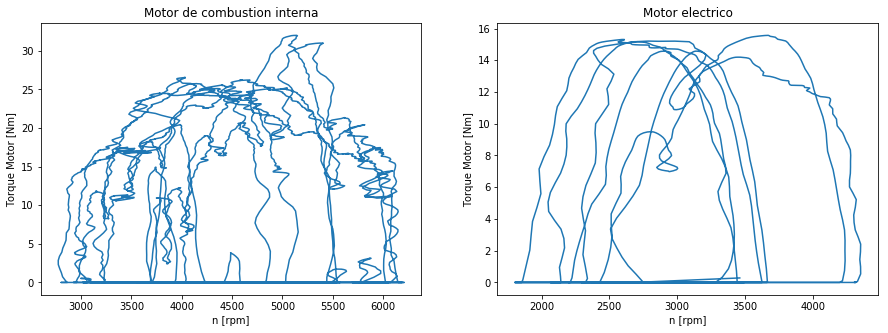

In [16]:
figure(figsize=(15,5))
plt.subplot(1,2,1)
n1=np.array(comb[1])*(30/3.141593)
plot(n1,comb[0])
title("Motor de combustion interna")
xlabel("n [rpm]")
ylabel ("Torque Motor [Nm]")
plt.subplot(1,2,2)
n2=np.array(elec[1])*(30/3.141593)
plot(n2,elec[0])
title("Motor electrico")
xlabel("n [rpm]")
ylabel ("Torque Motor [Nm]")

A partir de las gráficas anteriores se observa que los motores no tienen velocidades angulares de operación muy distintas pero los torques que entregane n magnitud los del motor de combustión son el doble que los del motor eléctrico. Para las dos graficas los comportamientos son los comportamientos típicos de un motor de cada tipo,en el caso del motor a combustión a bajas velocidades se consiguen bajas torques, sobre un rango de velocidades el torque se mantiene en valores altos y a muy altas velocidades el torque vuelve a disminuir. Y en el caso del electrico a altas velocidades tambien se disminuye el torque. 

Como opción de mejora si se espera obtener mejores resultados en el kart eléctrico una opción podría ser lograr disminuir las variables del kart como por ejemplo la masa, sin embargo no considero que sea una opción muy viable debido a que las baterías que requiere un motor eléctrico tienen un peso considerable y una disminución en las baterías genera un baja en la autonomía del kart, algo que no se puede permitir. Respecto a mejoras en la transmisión se observa que la transmisión está llevando a que el kart alcance tanto valores de torque cercanos al máximo como revoluciones también cercanas a la máxima por lo que se puede afirmar que la relacion es la adecuada(Tabla 2):

##### Tabla 2 Valores máximos de torque y velocidad angular del motor eléctrico en pista y en la caracterización
|             | Vuelta  | Caracterización [2]|
|-------------|---------|--------------------|
| Torque [Nm] | 15.57   | 15.2               |
| n [rpm]     | 4353.81 | 5000               |

Si se quiere obtener un mejor rendimiento mi recomendación es cambiar el motor por uno que permita generar un mayor torque y lleve a ganar aceleración en el kart. Con esto se estaría acercando el comportamiento del motor eléctrico al de combustión.

### Referencias

[1] 	M. Córdoba Parra, «Diseño de un tren de potencia para un kart eléctrico,» Universidad de los Andes, Bogota, 2016.

[2] 	D. G. Clavijo Pelayo, «Análisis, simulación e implementación de mejora del rendimiento para un kart eléctrico,» Universidad de los Andes, Bogota, 2017.